Visual similarity search using image embedding involves several steps. First, a pretrained neural network, such as a convolutional neural network (CNN), is used to extract visual features from images, which are represented as vector embeddings in a lower-dimensional space that preserves relative dissimilarity. These vector embeddings are then stored in a database for efficient retrieval.

When a user inputs an image for similarity search, the same pretrained network is used to extract visual features from the input image and obtain its vector embedding in the same embedding space as the stored embeddings. The distance between the vector embedding of the input image and all the vector embeddings in the database is calculated using distance metrics such as Euclidean distance or cosine distance, which measure the similarity or dissimilarity between the embeddings.

Based on the calculated distances, the k-Nearest Neighbours (k-NN) algorithm is used to find the k most similar image embeddings in the database. These k nearest neighbours represent the most visually similar products or images to the input image, and the results can be displayed to the user. To evaluate the success of the similarity search algorithm, subjective metrics such as hit-rate and A/B tests can be used to measure the accuracy of the recommendations.

In summary, visual similarity search using image embedding involves extracting visual features, representing them as vector embeddings, and comparing the embeddings to find visually similar products or images in a database. Evaluation of the algorithm can be done using subjective metrics and testing to ensure accurate recommendations.

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"himanshuberad","key":"da7aa8f9a27940bd26d95898b2f7f470"}'}

In [ ]:
#create a JSON Folder
! mkdir ~/.kaggle

In [ ]:
#Copy Kaggle.json to folder created

! cp kaggle.json ~/.kaggle/


In [ ]:
#Permission For Json to act
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                   title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023                          Global Country Information Dataset 2023             23KB  2023-07-08 20:37:33          11504        457  1.0              
nelgiriyewithana/global-youtube-statistics-2023                       Global YouTube Statistics 2023                      60KB  2023-07-28 15:36:38           3570        135  1.0              
joebeachcapital/global-earth-temperatures                             Global Earth Temperatures                           33KB  2023-08-09 06:21:51            750         29  1.0              
joebeachcapital/top-500-hollywood-m

In [ ]:
! kaggle datasets download -d paramaggarwal/fashion-product-images-dataset

100% 23.1G/23.1G [04:08<00:00, 145MB/s]
100% 23.1G/23.1G [04:08<00:00, 99.6MB/s]


In [ ]:
! unzip fashion-product-images-dataset

Streaming output truncated to the last 5000 lines.
  inflating: fashion-dataset/images/25241.jpg  
  inflating: fashion-dataset/images/25242.jpg  
  inflating: fashion-dataset/images/25243.jpg  
  inflating: fashion-dataset/images/25244.jpg  
  inflating: fashion-dataset/images/25245.jpg  
  inflating: fashion-dataset/images/25246.jpg  
  inflating: fashion-dataset/images/25247.jpg  
  inflating: fashion-dataset/images/25248.jpg  
  inflating: fashion-dataset/images/25249.jpg  
  inflating: fashion-dataset/images/25250.jpg  
  inflating: fashion-dataset/images/25251.jpg  
  inflating: fashion-dataset/images/25252.jpg  
  inflating: fashion-dataset/images/25253.jpg  
  inflating: fashion-dataset/images/25254.jpg  
  inflating: fashion-dataset/images/25256.jpg  
  inflating: fashion-dataset/images/25257.jpg  
  inflating: fashion-dataset/images/25258.jpg  
  inflating: fashion-dataset/images/25259.jpg  
  inflating: fashion-dataset/images/25260.jpg  
  inflating: fashion-dataset/images/2

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 16

In [ ]:
img_path = '/content/fashion-dataset/fashion-dataset/images'
img_df = pd.read_csv('/content/fashion-dataset/fashion-dataset/images.csv')
styles_df = pd.read_csv('/content/fashion-dataset/fashion-dataset/styles.csv', on_bad_lines='skip')

In [ ]:
img_df.head()

filename                                               link
0  15970.jpg  http://assets.myntassets.com/v1/images/style/p...
1  39386.jpg  http://assets.myntassets.com/v1/images/style/p...
2  59263.jpg  http://assets.myntassets.com/v1/images/style/p...
3  21379.jpg  http://assets.myntassets.com/v1/images/style/p...
4  53759.jpg  http://assets.myntassets.com/v1/images/style/p...

In [ ]:
styles_df.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt

In [ ]:
styles_df['filename'] = styles_df['id'].astype(str) + '.jpg'

In [ ]:
styles_df

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44419  17036    Men       Footwear       Shoes           Casual Shoes   
44420   6461    Men       Footwear  Flip Flops             Flip Flops   
44421  18842    Men        Apparel     Topwear                Tshirts   
44422  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44423  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
44419      White  Summer  2013.0  Casual   
44420        Red  Summer  2011.0  Casual   
44421       Blue    Fall  2011.0  Casual   
44422       Blue  Spring  2017.0  Casual   
44423       Pink  Winter  2016.0  Casual   

                                    productDisplayName   filename  
0                     Turtle Check Men Navy Blue Shirt  15970.jpg  
1                   Peter England Men Party Blue Jeans  39386.jpg  
2                             Titan Women Silver Watch  59263.jpg  
3        Manchester United Men Solid Black Track Pants  21379.jpg  
4                                Puma Men Grey T-shirt  53759.jpg  
...                                                ...        ...  
44419                        Gas Men Caddy Casual Shoe  17036.jpg  
44420               Lotto Men's Soccer Track Flip Flop   6461.jpg  
44421             Puma Men Graphic Stellar Blue Tshirt  18842.jpg  
44422                   Rasasi Women Blue Lady Perfume  46694.jpg  
44423  Fossil Women Pink Dial Chronograph Watch ES3050  51623.jpg  

[44424 rows x 11 columns]

In [ ]:
img_files = os.listdir(img_path)

In [ ]:
styles_df['present'] = styles_df['filename'].apply(lambda x:x in img_files)

In [ ]:
styles_df = styles_df[styles_df['present']].reset_index(drop=True)

In [ ]:
styles_df = styles_df.sample(10000)

In [ ]:
img_size = 224

datagen = ImageDataGenerator(rescale=1/255.)

generator = datagen.flow_from_dataframe(dataframe = styles_df,
                                       directory = img_path,
                                       target_size = (img_size,img_size),
                                       x_col = 'filename',
                                       class_mode = None,
                                       batch_size = 32,
                                       shuffle = False,
                                       classes= None)

Found 10000 validated image filenames.


In [ ]:
base_model = VGG16(include_top=False, input_shape= (img_size,img_size,3))

for layer in base_model.layers:
    layer.trainable = False


input_layer = Input(shape=(img_size,img_size,3))
x= base_model(input_layer)
output= GlobalAveragePooling2D()(x)

embeddings = Model(inputs = input_layer, outputs= output)
embeddings.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
X = embeddings.predict(generator, verbose=1)

313/313 [==============================] - 251s 764ms/step


# PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(2)
X_pca = pca.fit_transform(X)

In [ ]:
styles_df[['pc1', 'pc2']] = X_pca

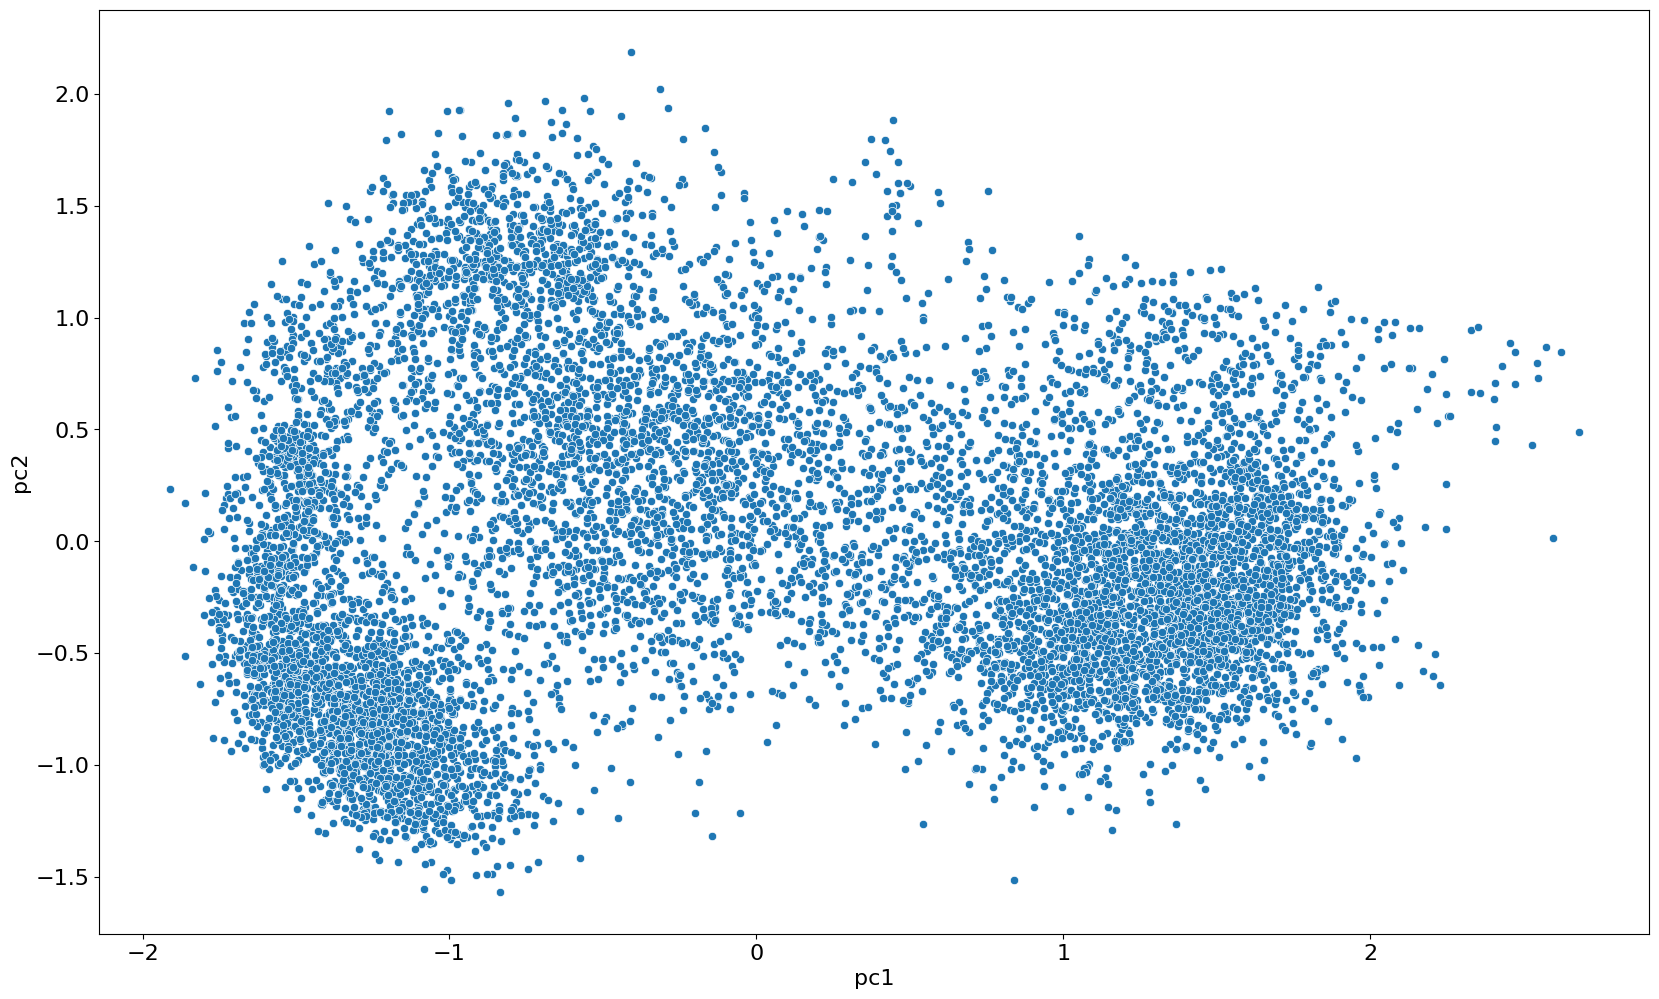

In [ ]:
plt.figure(figsize= (20,12))
sns.scatterplot(x='pc1',y='pc2',data = styles_df)
plt.show()

In [ ]:
def read_img(image_path):
    image = load_img(os.path.join(img_path,image_path),target_size=(img_size,img_size,3))
    image = img_to_array(image)
    image = image/255.
    return image

In [ ]:
import random
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
y = styles_df['id']

In [ ]:
nearest_neighbors = KNeighborsClassifier(n_neighbors = 7)
nearest_neighbors.fit(X,y)

KNeighborsClassifier(n_neighbors=7)

In [ ]:
styles_df = styles_df.reset_index(drop=True)

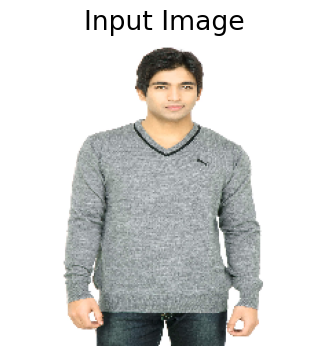

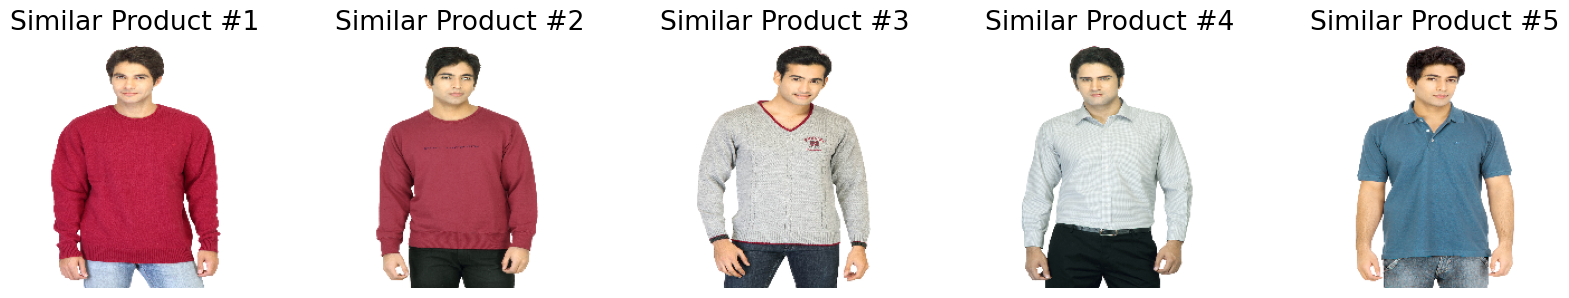

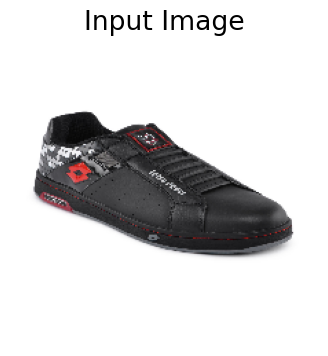

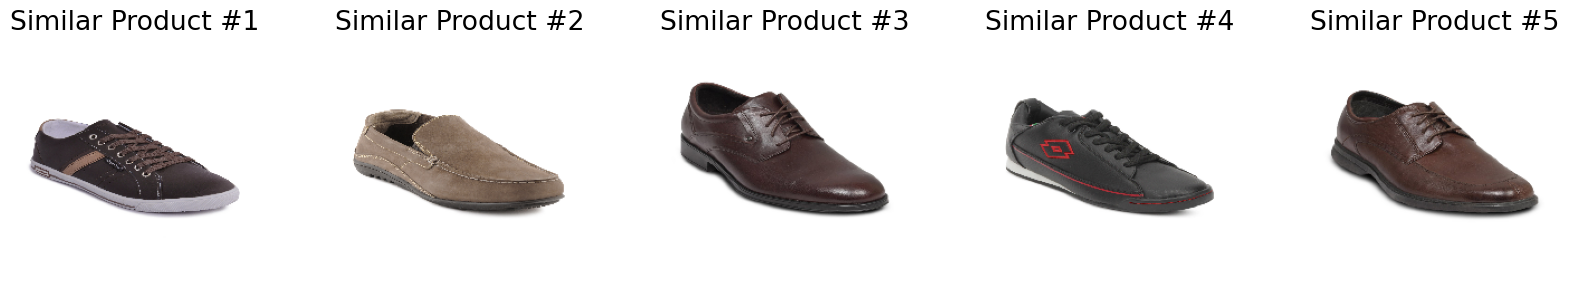

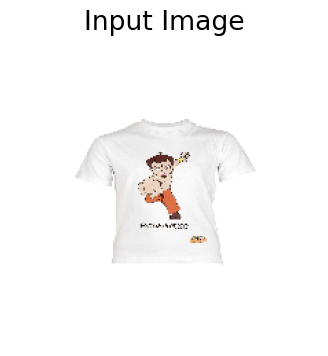

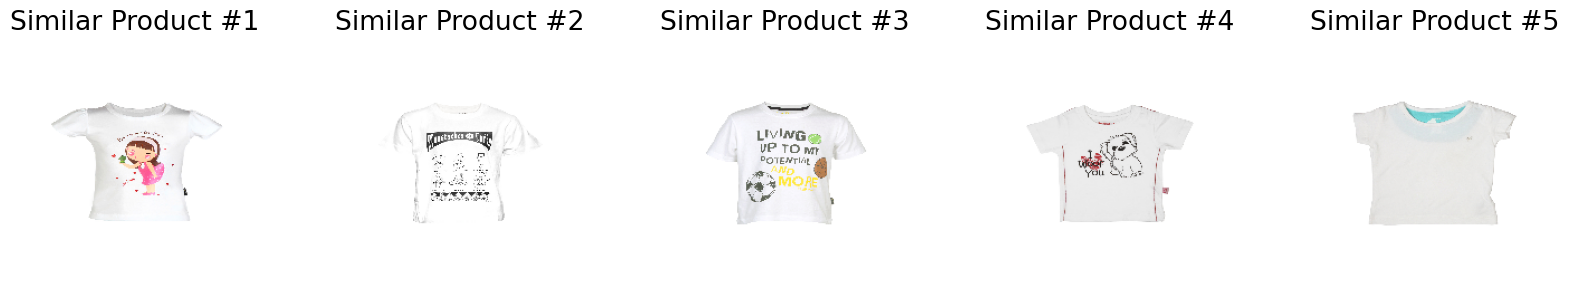

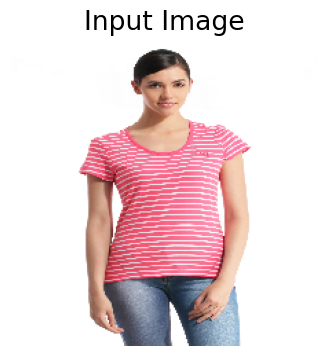

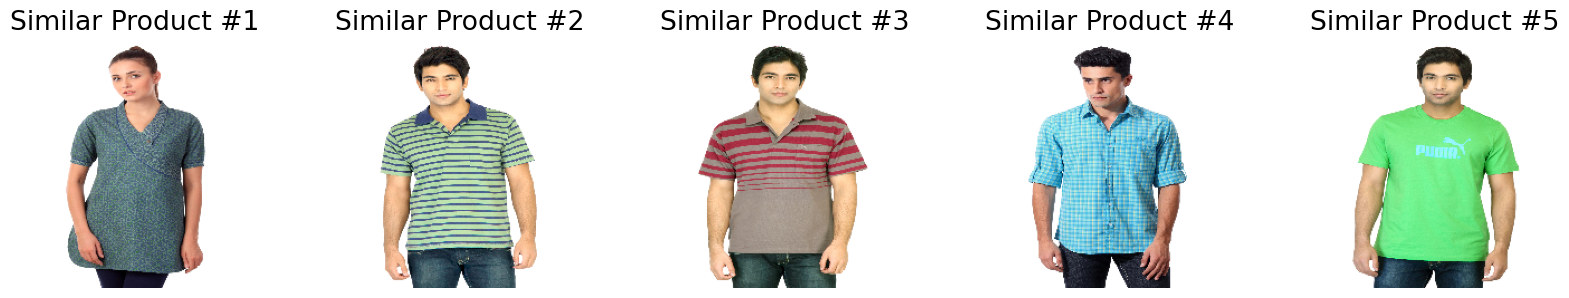

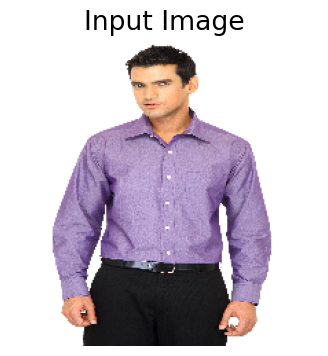

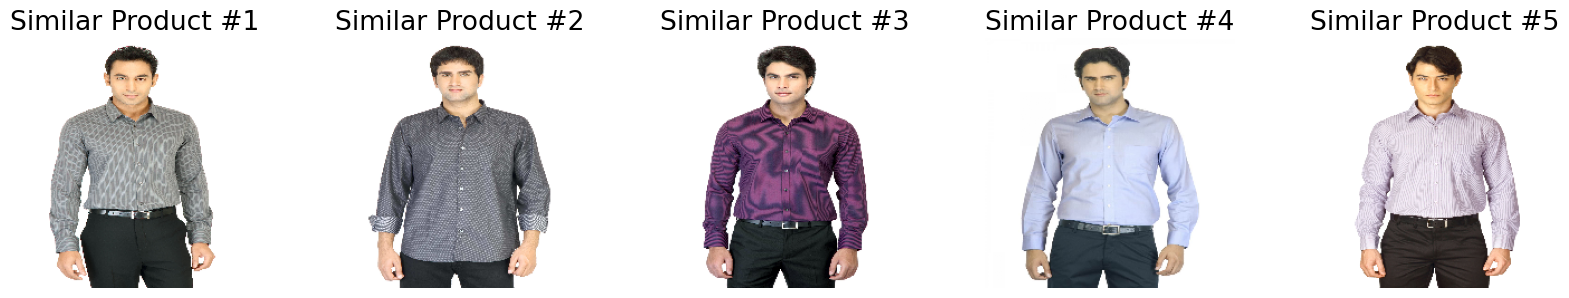

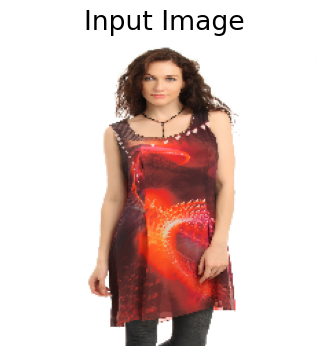

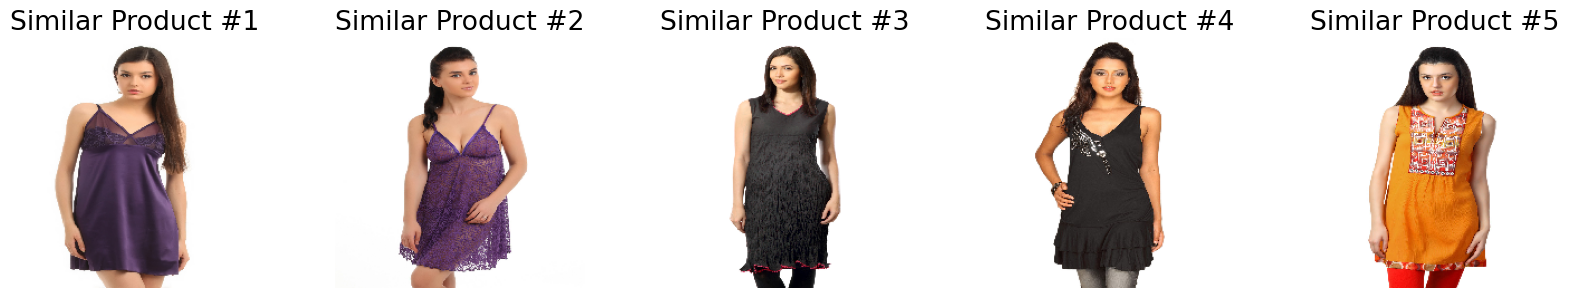

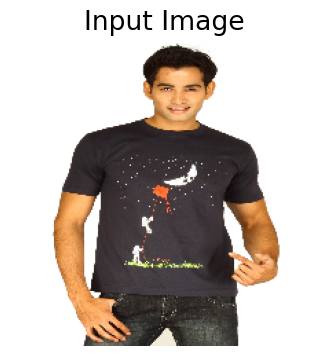

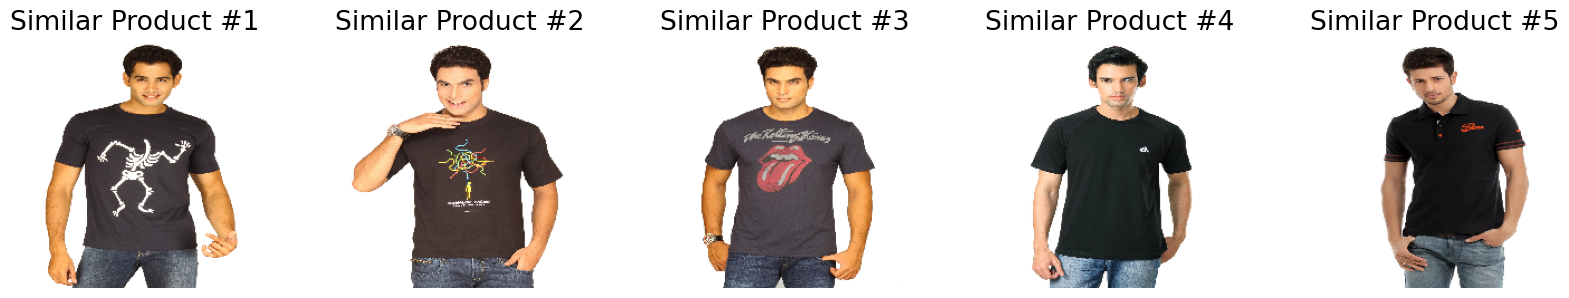

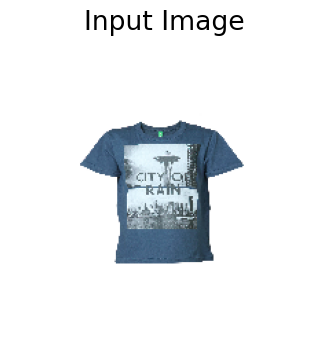

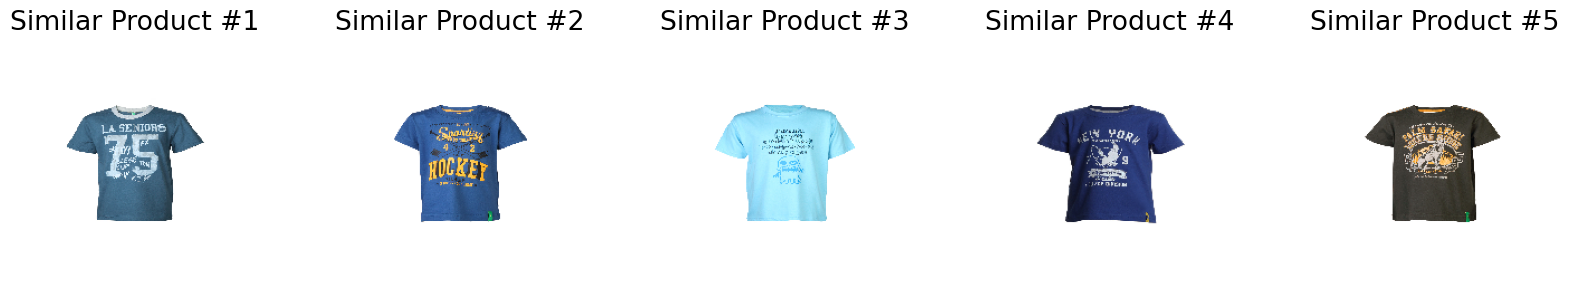

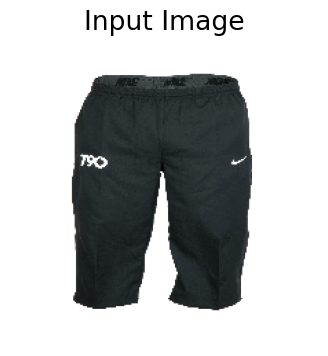

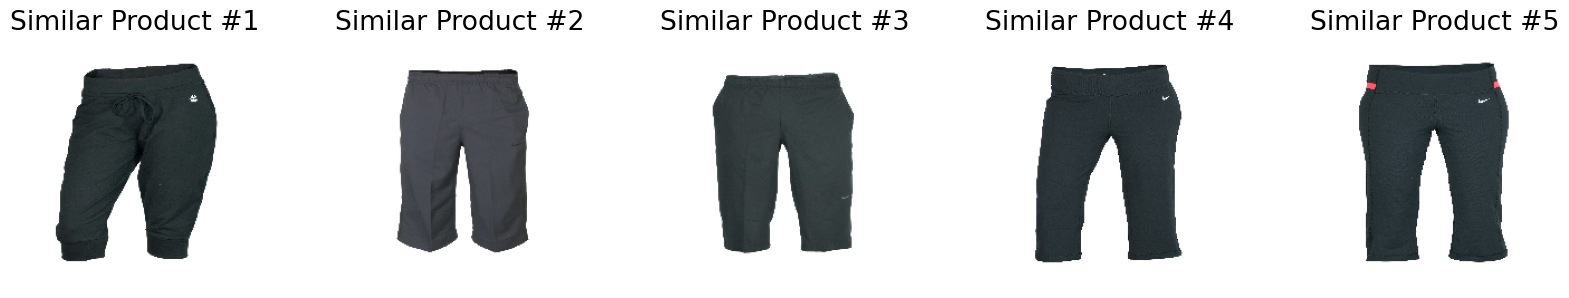

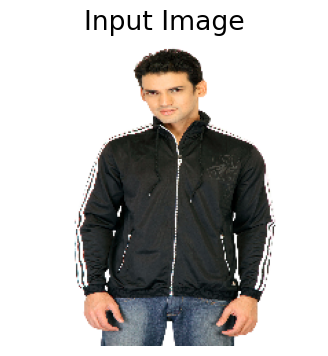

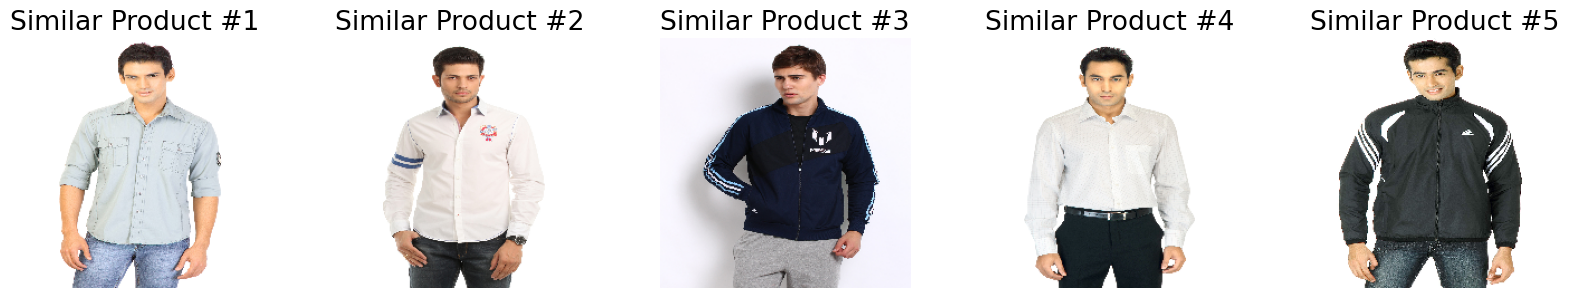

In [ ]:
for _ in range(10):
    i = random.randint(0,len(styles_df))
    img1 = read_img(styles_df.loc[i,'filename'])
    dist, index = nearest_neighbors.kneighbors(X=X[i,:].reshape(1,-1))
    plt.figure(figsize = (4 , 4))
    plt.imshow(img1)
    plt.title("Input Image")
    plt.axis('off')

    plt.figure(figsize = (20 , 20))
    for i in range(1,6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = read_img(styles_df.loc[index[0][i],'filename'])
        plt.imshow(image)
        plt.title(f'Similar Product #{i}')
        plt.axis('off')

give reason as to why its similar based on observation